# Predicting the cost of housing

# Description of the project

In the project, you need to train a linear regression model based on housing data in California in 1990. Based on the data, it is necessary to predict the median cost of a house in a residential area. Train the model and make predictions on the test sample. To assess the quality of the model, use the RMSE, MAE and R2 metrics.

## Importing and installing the necessary libraries

In [42]:
import numpy as np
import pandas as pd 
import phik
import plotly
import pyspark
import seaborn as sns

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go
import pyspark.sql.functions as F

from phik import report
from phik import resources
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode
from plotly.offline import iplot
from plotly.offline import plot

from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import *

In [43]:
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

In [44]:
init_notebook_mode(connected=True)

## Initializing the local spark session

In [45]:
RANDOM_SEED = 2023

spark = SparkSession.builder \
                    .master("local") \
                    .appName("Project - California_real_estate") \
                    .getOrCreate()

## Data preparation

We read the data and write it to the variable df

In [46]:
df = spark.read.option('header', 'true').csv('california_real_estate.csv', inferSchema = True) 

Let's print the first 5 lines

In [47]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|                41|        880|           129|       322|       126|       8.3252|            452600|       NEAR BAY|
|  -122.22|   37.86|                21|       7099|          1106|      2401|      1138|       8.3014|            358500|       NEAR BAY|
|  -122.24|   37.85|                52|       1467|           190|       496|       177|       7.2574|            352100|       NEAR BAY|
|  -122.25|   37.85|                52|       1274|           235|       558|       219|       5.6431|            341300|       NEAR BAY|
|  -122.25|   37.85|              

Let's look at the data type in the columns

In [48]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: integer (nullable = true)
 |-- ocean_proximity: string (nullable = true)



We see that in the ocean_proximity variable the data type is string, in the rest it is double. Let's turn to the literature to understand what it is. Okay, this is a float type with two decimal places. I think that the data type does not need to be changed.

Let's output general information about the dataframe

In [49]:
df.describe().toPandas()

summary            longitude           latitude  housing_median_age  \
0   count                20640              20640               20640   
1    mean  -119.56970445736148   35.6318614341087  28.639486434108527   
2  stddev    2.003531723502584  2.135952397457101   12.58555761211163   
3     min              -124.35              32.54                   1   
4     max              -114.31              41.95                  52   

          total_rooms      total_bedrooms          population  \
0               20640               20433               20640   
1  2635.7630813953488   537.8705525375618  1425.4767441860465   
2  2181.6152515827944  421.38507007403115    1132.46212176534   
3                   2                   1                   3   
4               39320                6445               35682   

          households       median_income  median_house_value ocean_proximity  
0              20640               20640               20640           20640  
1  499.5396802325581  3.8706710029070246  206855.81690891474            None  
2  382.3297528316098   1.899821717945263  115395.61587441359            None  
3                  1              0.4999               14999       <1H OCEAN  
4               6082             15.0001              500001      NEAR OCEAN

Let's print the number of gaps in columns of the float type

In [50]:
columns = df.columns

for column in columns:
    check_col = F.col(column).cast(FloatType())
    print(column, df.filter(check_col.isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 20640


There are 207 missing values in the total_bedrooms column. The ocean_proximity column indicates 20640 omissions, but in fact there are none. This happened due to the translation of string to float. In the column above, where we called the describe() method, we see the number of values equal to the number of rows

Before working with the gaps, let's look at the histograms

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

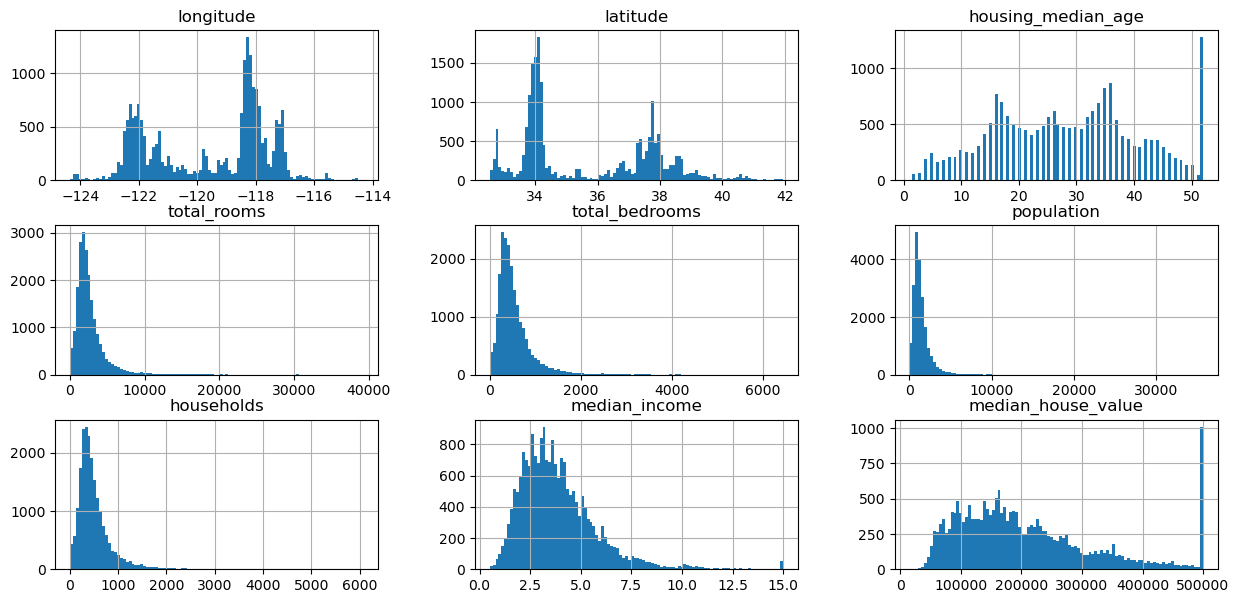

In [51]:
df.toPandas().hist(figsize=(15, 7), bins=100)

In [52]:
dict_names = {
 'longitude': 'longitude',
 'latitude': 'latitude',
 'housing_median_age': 'the median age of the residents of the residential area',
 'total_rooms': 'the total number of rooms in the houses of the residential area',
 'total_bedrooms': 'the total number of bedrooms in residential buildings',
 'population': 'the number of people who live in a residential area',
 'households': 'the number of households in the residential area',
 'median_income': 'median income of residential area residents',
 'median_house_value': 'the median cost of a house in a residential area',
 'ocean_proximity': 'proximity to the ocean'
}

In [53]:
for i in list(df.columns):
    fig = px.histogram(df.toPandas(), x=i)
    fig.update_layout(bargap=0.2, title_text='A histogram of the distribution of column values '+i+'('+dict_names[i]+')')
    fig.update_yaxes(title_text = 'frequency')
    iplot(fig, show_link=True)

In [54]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

Fill in the gaps with medians

In [55]:
median_total_bedrooms = df.select('total_bedrooms').toPandas().median().item()

In [56]:
df = df.fillna(median_total_bedrooms)

Let's check what happened to the missing values

In [57]:
df.describe().toPandas()

summary            longitude           latitude  housing_median_age  \
0   count                20640              20640               20640   
1    mean  -119.56970445736148   35.6318614341087  28.639486434108527   
2  stddev    2.003531723502584  2.135952397457101   12.58555761211163   
3     min              -124.35              32.54                   1   
4     max              -114.31              41.95                  52   

          total_rooms      total_bedrooms          population  \
0               20640               20640               20640   
1  2635.7630813953488   536.8388565891473  1425.4767441860465   
2  2181.6152515827944  419.39187792168866    1132.46212176534   
3                   2                   1                   3   
4               39320                6445               35682   

          households       median_income  median_house_value ocean_proximity  
0              20640               20640               20640           20640  
1  499.5396802325581  3.8706710029070246  206855.81690891474            None  
2  382.3297528316098   1.899821717945263  115395.61587441359            None  
3                  1              0.4999               14999       <1H OCEAN  
4               6082             15.0001              500001      NEAR OCEAN

Let's check the correlation of features using the pil library

interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


<AxesSubplot:>

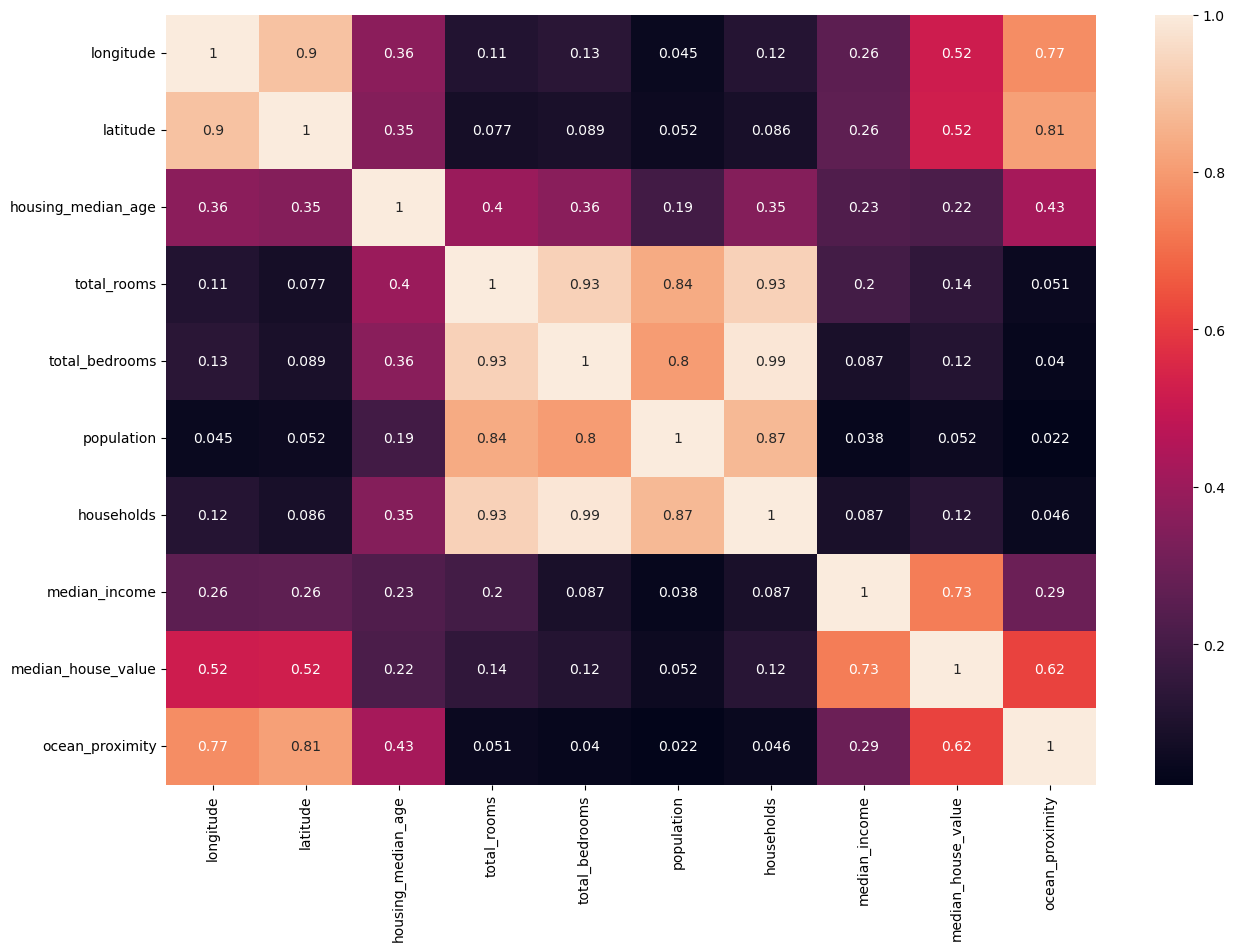

In [58]:
phik_corr = df.toPandas().phik_matrix()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(phik_corr, annot=True)

total_rooms, total_bedrooms and households strongly correlate with each other

## Let's move on to the transformation of features

### Transformation of categorical features

Let's create lists with categorical, quantitative attributes and a target

In [59]:
cat = 'ocean_proximity'
num = [
    'longitude', 
    'latitude', 
    'housing_median_age', 
    'total_rooms', 
    'total_bedrooms', 
    'population',
    'households', 
    'median_income'
]
target = 'median_house_value'

Indexing the data in the ocean_proximity_Index column

In [60]:
category_indexer = StringIndexer(inputCol=cat, outputCol='ocean_proximity_Index')

We transform the data in the ocean_proximity_Index column obtained at the last stage using OHE

In [61]:
encoder_cat = OneHotEncoder(inputCol="ocean_proximity_Index", outputCol="ocean_proximity_Vec")

###  Transformation of numerical features

Using VectorAssembler, we assemble numeric variables into one vector

In [62]:
numerical_assembler = VectorAssembler(inputCols=num, outputCol="numerical_features")

We standardize the data obtained in the last step

In [63]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol="numerical_features_scaled", withStd=True, withMean=True)

We collect categorical and numerical features in one vector

In [64]:
all_features = ['ocean_proximity_Vec','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

### We divide the samples into test and training ones

In [65]:
train_data, test_data = df.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16519 4121


Let's leave the sample for training the model without categorical features

In [66]:
train_data_num = train_data.select('*')
test_data_num = test_data.select('*')

In [67]:
print(train_data_num.count(), test_data_num.count())

16519 4121


## Model Training

### We train the model on all features

In [68]:
lr = LinearRegression(labelCol=target, featuresCol='features')

In [69]:
pipeline = Pipeline(stages=[category_indexer, encoder_cat, numerical_assembler, standardScaler, final_assembler, lr])

In [70]:
model = pipeline.fit(train_data)

Predicting data on a training sample

In [71]:
predictions_train = model.transform(train_data)
predictions_train.toPandas().head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -124.35     40.54                  52         1820             300   
1    -124.30     41.80                  19         2672             552   
2    -124.30     41.84                  17         2677             531   
3    -124.27     40.69                  36         2349             528   
4    -124.26     40.58                  52         2217             394   

   population  households  median_income  median_house_value ocean_proximity  \
0         806         270         3.0147               94600      NEAR OCEAN   
1        1298         478         1.9797               85800      NEAR OCEAN   
2        1244         456         3.0313              103600      NEAR OCEAN   
3        1194         465         2.5179               79000      NEAR OCEAN   
4         907         369         2.3571              111400      NEAR OCEAN   

   ocean_proximity_Index   ocean_proximity_Vec  \
0                    2.0  (0.0, 0.0, 1.0, 0.0)   
1                    2.0  (0.0, 0.0, 1.0, 0.0)   
2                    2.0  (0.0, 0.0, 1.0, 0.0)   
3                    2.0  (0.0, 0.0, 1.0, 0.0)   
4                    2.0  (0.0, 0.0, 1.0, 0.0)   

                                  numerical_features  \
0  [-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 2...   
1  [-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 47...   
2  [-124.3, 41.84, 17.0, 2677.0, 531.0, 1244.0, 4...   
3  [-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, ...   
4  [-124.26, 40.58, 52.0, 2217.0, 394.0, 907.0, 3...   

                           numerical_features_scaled  \
0  [-2.384236425672673, 2.3000943591856298, 1.852...   
1  [-2.3592948725702763, 2.890427981060966, -0.77...   
2  [-2.3592948725702763, 2.9091687309617735, -0.9...   
3  [-2.3443299407088367, 2.3703721713136456, 0.57...   
4  [-2.339341630088361, 2.3188351090864336, 1.852...   

                                            features     prediction  
0  [0.0, 0.0, 1.0, 0.0, -2.384236425672673, 2.300...  212606.159714  
1  [0.0, 0.0, 1.0, 0.0, -2.3592948725702763, 2.89...  114805.423616  
2  [0.0, 0.0, 1.0, 0.0, -2.3592948725702763, 2.90...  150858.288698  
3  [0.0, 0.0, 1.0, 0.0, -2.3443299407088367, 2.37...  183807.189816  
4  [0.0, 0.0, 1.0, 0.0, -2.339341630088361, 2.318...  193302.745640

We output metrics for the training sample

In [72]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
r2_train_full = evaluator.evaluate(predictions_train)
print(f"R2_train_full: {r2_train_full}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse_train_full = evaluator.evaluate(predictions_train)
print(f"RMSE_train_full: {rmse_train_full}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
mae_train_full = evaluator.evaluate(predictions_train)
print(f"MAE_train_full: {mae_train_full}")

R2_train_full: 0.6452714149372882
RMSE_train_full: 68576.77267016617
MAE_train_full: 49881.232384439


We check the model on the test data

In [73]:
predictions_test = model.transform(test_data)
predictions_test.toPandas().head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -124.22     41.73                  28         3003             699   
1    -124.18     40.78                  34         1592             364   
2    -124.17     40.80                  52         1557             344   
3    -124.15     40.76                  24         2858             511   
4    -124.15     40.78                  41         2127             358   

   population  households  median_income  median_house_value ocean_proximity  \
0        1530         653         1.7038               78300      NEAR OCEAN   
1         950         317         2.1607               67000      NEAR OCEAN   
2         758         319         1.8529               62500      NEAR OCEAN   
3        1388         512         3.3750              100600      NEAR OCEAN   
4         911         349         3.1711              104200      NEAR OCEAN   

   ocean_proximity_Index   ocean_proximity_Vec  \
0                    2.0  (0.0, 0.0, 1.0, 0.0)   
1                    2.0  (0.0, 0.0, 1.0, 0.0)   
2                    2.0  (0.0, 0.0, 1.0, 0.0)   
3                    2.0  (0.0, 0.0, 1.0, 0.0)   
4                    2.0  (0.0, 0.0, 1.0, 0.0)   

                                  numerical_features  \
0  [-124.22, 41.73, 28.0, 3003.0, 699.0, 1530.0, ...   
1  [-124.18, 40.78, 34.0, 1592.0, 364.0, 950.0, 3...   
2  [-124.17, 40.8, 52.0, 1557.0, 344.0, 758.0, 31...   
3  [-124.15, 40.76, 24.0, 2858.0, 511.0, 1388.0, ...   
4  [-124.15, 40.78, 41.0, 2127.0, 358.0, 911.0, 3...   

                           numerical_features_scaled  \
0  [-2.3193883876064394, 2.8576316687345584, -0.0...   
1  [-2.2994351451245247, 2.412538858590457, 0.420...   
2  [-2.2944468345040425, 2.421909233540857, 1.852...   
3  [-2.284470213263085, 2.4031684836400533, -0.37...   
4  [-2.284470213263085, 2.412538858590457, 0.9773...   

                                            features     prediction  
0  [0.0, 0.0, 1.0, 0.0, -2.3193883876064394, 2.85...  127350.756072  
1  [0.0, 0.0, 1.0, 0.0, -2.2994351451245247, 2.41...  152874.589208  
2  [0.0, 0.0, 1.0, 0.0, -2.2944468345040425, 2.42...  167008.577887  
3  [0.0, 0.0, 1.0, 0.0, -2.284470213263085, 2.403...  192197.090322  
4  [0.0, 0.0, 1.0, 0.0, -2.284470213263085, 2.412...  200811.885819

In [74]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
r2_test_full = evaluator.evaluate(predictions_test)
print(f"R2_test_full: {r2_test_full}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse_test_full = evaluator.evaluate(predictions_test)
print(f"RMSE_test_full: {rmse_test_full}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
mae_test_full = evaluator.evaluate(predictions_test)
print(f"MAE_test_full: {mae_test_full}")

R2_test_full: 0.6435527208848995
RMSE_test_full: 69492.82827727227
MAE_test_full: 49769.87052546838


### We train the model only on numerical features

In [75]:
lr_num = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled')

In [76]:
pipeline_num = Pipeline(stages=[numerical_assembler, standardScaler, lr_num])

In [77]:
model_num = pipeline_num.fit(train_data_num)

Predicting data on a training sample

In [78]:
predictions_train_num = model_num.transform(train_data_num)
predictions_train_num.toPandas().head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -124.35     40.54                  52         1820             300   
1    -124.30     41.80                  19         2672             552   
2    -124.30     41.84                  17         2677             531   
3    -124.27     40.69                  36         2349             528   
4    -124.26     40.58                  52         2217             394   

   population  households  median_income  median_house_value ocean_proximity  \
0         806         270         3.0147               94600      NEAR OCEAN   
1        1298         478         1.9797               85800      NEAR OCEAN   
2        1244         456         3.0313              103600      NEAR OCEAN   
3        1194         465         2.5179               79000      NEAR OCEAN   
4         907         369         2.3571              111400      NEAR OCEAN   

                                  numerical_features  \
0  [-124.35, 40.54, 52.0, 1820.0, 300.0, 806.0, 2...   
1  [-124.3, 41.8, 19.0, 2672.0, 552.0, 1298.0, 47...   
2  [-124.3, 41.84, 17.0, 2677.0, 531.0, 1244.0, 4...   
3  [-124.27, 40.69, 36.0, 2349.0, 528.0, 1194.0, ...   
4  [-124.26, 40.58, 52.0, 2217.0, 394.0, 907.0, 3...   

                           numerical_features_scaled     prediction  
0  [-2.384236425672673, 2.3000943591856298, 1.852...  188981.629202  
1  [-2.3592948725702763, 2.890427981060966, -0.77...   65918.668880  
2  [-2.3592948725702763, 2.9091687309617735, -0.9...  101925.101590  
3  [-2.3443299407088367, 2.3703721713136456, 0.57...  155733.081100  
4  [-2.339341630088361, 2.3188351090864336, 1.852...  167197.797299

We output metrics for the training sample

In [79]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
r2_train_num = evaluator.evaluate(predictions_train_num)
print(f"R2_train_num: {r2_train_num}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse_train_num = evaluator.evaluate(predictions_train_num)
print(f"RMSE_train_num: {rmse_train_num}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
mae_train_num = evaluator.evaluate(predictions_train_num)
print(f"MAE_train_num: {mae_train_num}")

R2_train_num: 0.6358340454506997
RMSE_train_num: 69483.00942842719
MAE_train_num: 50941.935797538536


We check the model on the test data

In [80]:
predictions_test_num = model_num.transform(test_data_num)
predictions_test_num.toPandas().head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -124.22     41.73                  28         3003             699   
1    -124.18     40.78                  34         1592             364   
2    -124.17     40.80                  52         1557             344   
3    -124.15     40.76                  24         2858             511   
4    -124.15     40.78                  41         2127             358   

   population  households  median_income  median_house_value ocean_proximity  \
0        1530         653         1.7038               78300      NEAR OCEAN   
1         950         317         2.1607               67000      NEAR OCEAN   
2         758         319         1.8529               62500      NEAR OCEAN   
3        1388         512         3.3750              100600      NEAR OCEAN   
4         911         349         3.1711              104200      NEAR OCEAN   

                                  numerical_features  \
0  [-124.22, 41.73, 28.0, 3003.0, 699.0, 1530.0, ...   
1  [-124.18, 40.78, 34.0, 1592.0, 364.0, 950.0, 3...   
2  [-124.17, 40.8, 52.0, 1557.0, 344.0, 758.0, 31...   
3  [-124.15, 40.76, 24.0, 2858.0, 511.0, 1388.0, ...   
4  [-124.15, 40.78, 41.0, 2127.0, 358.0, 911.0, 3...   

                           numerical_features_scaled     prediction  
0  [-2.3193883876064394, 2.8576316687345584, -0.0...   79818.012318  
1  [-2.2994351451245247, 2.412538858590457, 0.420...  121043.801205  
2  [-2.2944468345040425, 2.421909233540857, 1.852...  135974.333550  
3  [-2.284470213263085, 2.4031684836400533, -0.37...  159635.251579  
4  [-2.284470213263085, 2.412538858590457, 0.9773...  169149.121475

In [81]:
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
r2_test_num = evaluator.evaluate(predictions_test_num)
print(f"R2_test_num: {r2_test_num}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
rmse_test_num = evaluator.evaluate(predictions_test_num)
print(f"RMSE_test_num: {rmse_test_num}")

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
mae_test_num = evaluator.evaluate(predictions_test_num)
print(f"MAE_test_num: {mae_test_num}")

R2_test_num: 0.6319945145819088
RMSE_test_num: 70610.53165162637
MAE_test_num: 50974.966045955734


# Analysis of the results

Let's output the metrics of the two models for comparison

Metrics of a model without a categorical feature

In [82]:
print(f"R2_test_full: {r2_test_full}")
print(f"RMSE_test_full: {rmse_test_full}")
print(f"MAE_test_full: {mae_test_full}")

R2_test_full: 0.6435527208848995
RMSE_test_full: 69492.82827727227
MAE_test_full: 49769.87052546838


Metrics of a model without a categorical feature

In [83]:
print(f"R2_test_num: {r2_test_num}")
print(f"RMSE_test_num: {rmse_test_num}")
print(f"MAE_test_num: {mae_test_num}")

R2_test_num: 0.6319945145819088
RMSE_test_num: 70610.53165162637
MAE_test_num: 50974.966045955734


## Conclusion:

* Started by installing and importing the necessary libraries
* Initialized the local spark session
* Read the data, checked the data type, found gaps in the total_bedrooms column
* Filled in the gaps with the median value
* Transformed the categorical variable via OHE
* Standardized numeric variables (Most likely made a mistake here. The data has not been standardized in the way I imagined it to be)
* Built two models: 1. with all variables, 2. without categorical
* The metrics turned out to be comparable, but the first model with categorical features turned out to be slightly better